In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.pipeline import make_pipeline

In [2]:
df = pd.read_csv('dataset.csv')
org = df.copy()

# Filter
df = df.loc[~df['Activity'].isin(['LIE_TO_STAND', 'STAND_TO_LIE'])]

activities_labels = ['STANDING', 'LAYING', 'SITTING', 'WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
transitions_labels = ['SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_SIT', 'SIT_TO_STAND']

X = df.drop(columns=['Activity'])
y = df['Activity']

# balanced_accuracy = (recall + specificity) / 2
metrics = ['f1_weighted', 'balanced_accuracy', 'accuracy']

# Sem atividade agregada

## Dropping non PT from test subset

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=42)

to_drop = []
for index, value in y_test.items():
    if value not in transitions_labels:
        to_drop.append(index)
X_test = X_test.drop(to_drop)
y_test = y_test.drop(to_drop)

## MLP Único

In [4]:
mlp = MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 500,
                    hidden_layer_sizes=(100,),
                    random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

                  precision    recall  f1-score   support

      LIE_TO_SIT       1.00      1.00      1.00        26
         SITTING       0.00      0.00      0.00         0
      SIT_TO_LIE       1.00      1.00      1.00        32
    SIT_TO_STAND       0.91      1.00      0.95        10
    STAND_TO_SIT       1.00      0.81      0.89        21
WALKING_UPSTAIRS       0.00      0.00      0.00         0

        accuracy                           0.96        89
       macro avg       0.65      0.63      0.64        89
    weighted avg       0.99      0.96      0.97        89



/home/gabriel/.pyenv/versions/anaconda3-2020.07/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


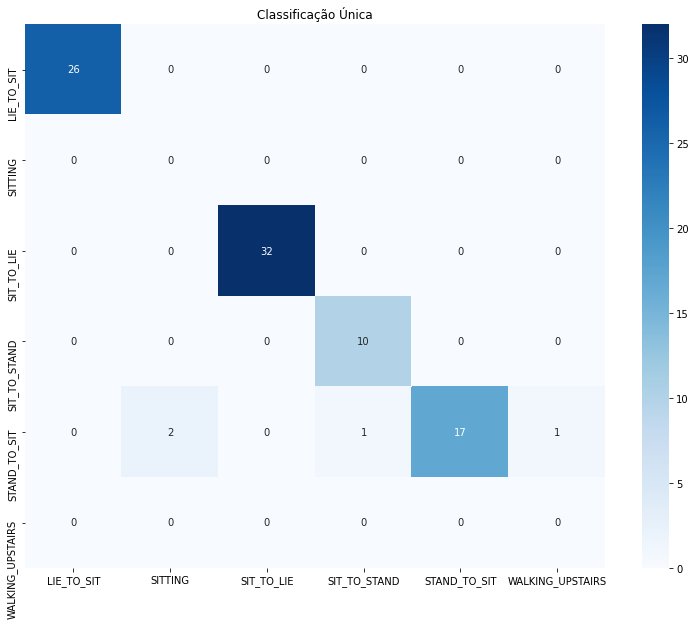

In [5]:
cf_matrix = confusion_matrix(y_test, y_pred)

categories = np.unique(y_pred).tolist()
plt.figure(figsize=(13,10))
plt.title('Classificação Única')
sns.heatmap(cf_matrix, annot=True, fmt="", cmap='Blues', cbar=True, xticklabels=categories, yticklabels=categories)

## Hierárquico

In [6]:
class_hierarchy = {
    ROOT: ["T", "NT"],
    "NT": activities_labels,
    "T": transitions_labels
}

base_estimator = {
    ROOT: SVC(C=100, kernel='rbf', probability=True, random_state=42),
    "NT": MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 500,
                    hidden_layer_sizes=(400,),
                    random_state=42),
    "T": KNeighborsClassifier(n_neighbors=7, n_jobs=-1),
}

clf = HierarchicalClassifier(
    base_estimator=base_estimator,
    class_hierarchy=class_hierarchy,
    prediction_depth='mlnp',
    algorithm='lcpn',
)

In [7]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

      LIE_TO_SIT       1.00      1.00      1.00        26
         SITTING       0.00      0.00      0.00         0
      SIT_TO_LIE       0.97      0.97      0.97        32
    SIT_TO_STAND       0.78      0.70      0.74        10
    STAND_TO_SIT       0.80      0.76      0.78        21
WALKING_UPSTAIRS       0.00      0.00      0.00         0

        accuracy                           0.90        89
       macro avg       0.59      0.57      0.58        89
    weighted avg       0.92      0.90      0.91        89



/home/gabriel/.pyenv/versions/anaconda3-2020.07/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


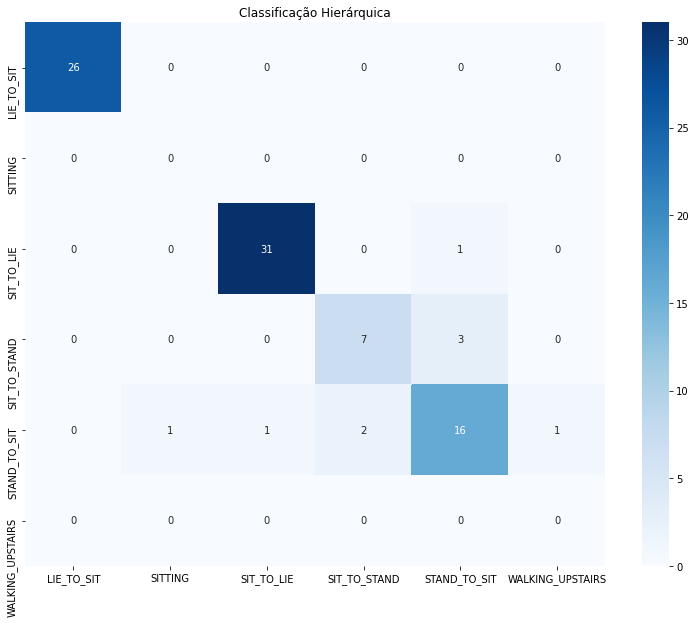

In [8]:
cf_matrix = confusion_matrix(y_test, y_pred)

categories = np.unique(y_pred).tolist()
plt.figure(figsize=(13,10))
plt.title('Classificação Hierárquica')
sns.heatmap(cf_matrix, annot=True, fmt="", cmap='Blues', cbar=True, xticklabels=categories, yticklabels=categories)

# Sem filtrar atividade agregada

In [9]:
X = org.drop(columns=['Activity'])
y = org['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=42)

transitions_labels = ['SIT_TO_LIE', 'LIE_TO_SIT',
                      'STAND_TO_SIT', 'SIT_TO_STAND',
                      'LIE_TO_STAND', 'STAND_TO_LIE']

to_drop = []
for index, value in y_test.items():
    if value not in transitions_labels:
        to_drop.append(index)
X_test = X_test.drop(to_drop)
y_test = y_test.drop(to_drop)

## MLP Único

In [10]:
mlp = MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 500,
                    hidden_layer_sizes=(200,),
                    random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

                  precision    recall  f1-score   support

          LAYING       0.00      0.00      0.00         0
      LIE_TO_SIT       0.79      0.85      0.81        26
    LIE_TO_STAND       0.80      0.64      0.71        25
         SITTING       0.00      0.00      0.00         0
      SIT_TO_LIE       0.74      0.91      0.82        32
    SIT_TO_STAND       0.83      1.00      0.91        10
        STANDING       0.00      0.00      0.00         0
    STAND_TO_LIE       0.92      0.79      0.85        42
    STAND_TO_SIT       1.00      0.62      0.76        21
WALKING_UPSTAIRS       0.00      0.00      0.00         0

        accuracy                           0.79       156
       macro avg       0.51      0.48      0.49       156
    weighted avg       0.85      0.79      0.81       156



/home/gabriel/.pyenv/versions/anaconda3-2020.07/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


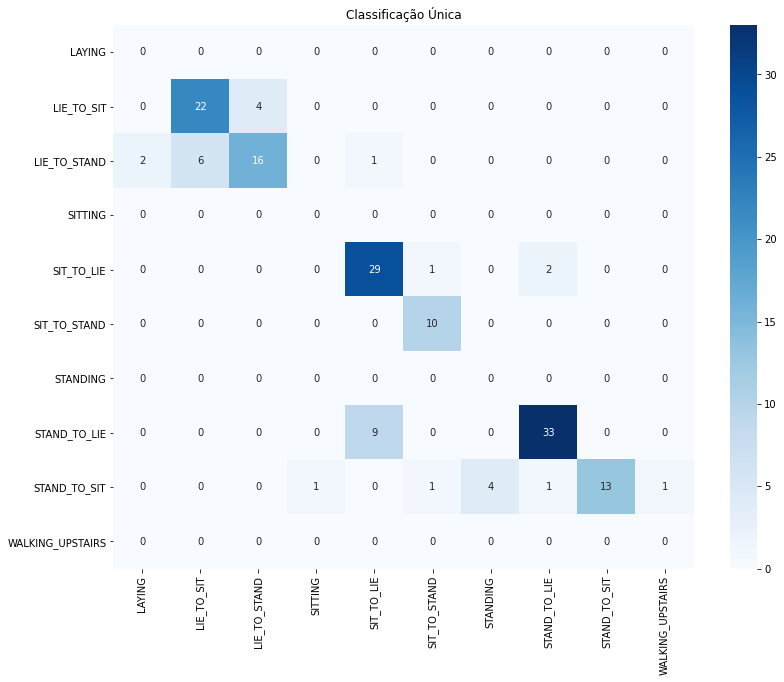

In [11]:
cf_matrix = confusion_matrix(y_test, y_pred)

categories = np.unique(y_pred).tolist()
plt.figure(figsize=(13,10))
plt.title('Classificação Única')
sns.heatmap(cf_matrix, annot=True, fmt="", cmap='Blues', cbar=True, xticklabels=categories, yticklabels=categories)

## Hierárquico

In [12]:
class_hierarchy = {
    ROOT: ["T", "NT"],
    "NT": activities_labels,
    "T": transitions_labels
}

steps = [
    BorderlineSMOTE(random_state=42, n_jobs=-1),
    MLPClassifier(activation = 'logistic',
                  solver='adam',
                  alpha=1e-5,
                  learning_rate = 'invscaling',
                  max_iter = 600,
                  hidden_layer_sizes=(125,),
                  random_state=42)
]
t_clf = make_pipeline(*steps)

base_estimator = {
    ROOT: SVC(C=100, kernel='rbf', probability=True, random_state=42),
    "NT": MLPClassifier(activation = 'logistic',
                        solver='adam',
                        alpha=1e-5,
                        learning_rate = 'invscaling',
                        max_iter = 500,
                        hidden_layer_sizes=(400,),
                        random_state=42),
    "T": t_clf,
}

clf = HierarchicalClassifier(
    base_estimator=base_estimator,
    class_hierarchy=class_hierarchy,
    prediction_depth='mlnp',
    algorithm='lcpn',
)

In [13]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

          LAYING       0.00      0.00      0.00         0
      LIE_TO_SIT       0.78      0.81      0.79        26
    LIE_TO_STAND       0.73      0.64      0.68        25
      SIT_TO_LIE       0.71      0.84      0.77        32
    SIT_TO_STAND       0.77      1.00      0.87        10
        STANDING       0.00      0.00      0.00         0
    STAND_TO_LIE       0.92      0.79      0.85        42
    STAND_TO_SIT       0.93      0.62      0.74        21
WALKING_UPSTAIRS       0.00      0.00      0.00         0

        accuracy                           0.77       156
       macro avg       0.54      0.52      0.52       156
    weighted avg       0.81      0.77      0.78       156



/home/gabriel/.pyenv/versions/anaconda3-2020.07/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


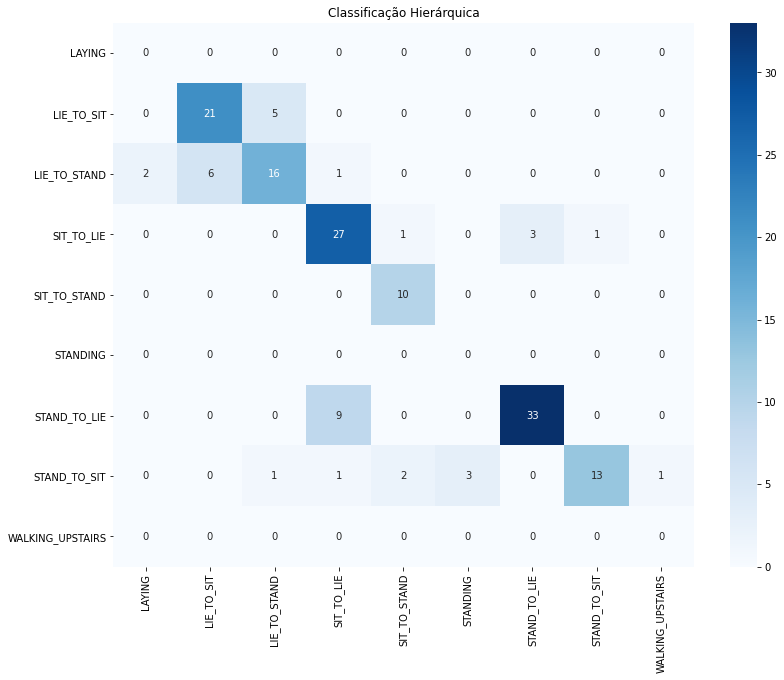

In [14]:
cf_matrix = confusion_matrix(y_test, y_pred)

categories = np.unique(y_pred).tolist()
plt.figure(figsize=(13,10))
plt.title('Classificação Hierárquica')
sns.heatmap(cf_matrix, annot=True, fmt="", cmap='Blues', cbar=True, xticklabels=categories, yticklabels=categories)

